<a href="https://colab.research.google.com/github/BlitzKingFr/Number-checker/blob/main/handwriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
import kagglehub

In [3]:
path = kagglehub.dataset_download("hojjatk/mnist-dataset")


print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mnist-dataset


In [4]:
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64,shuffle=True)

for X,y in test_loader:
  print(f"Shape of X [N,C,H,W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.01MB/s]

Shape of X [N,C,H,W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu" #checking if there is cuda or we have to use cpu
print(f"Using {device} device") #cuda avilable
class DigitClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1,32,3,1),
        nn.ReLU(),
        nn.Conv2d(32,64,3,1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(9216,128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128,10)
    )
  def forward(self,x):
    return self.net(x)

Using cuda device


In [6]:
model = DigitClassifier()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu" #checking if there is cuda or we have to use cpu
model.to(device)

for epoch in range(1,31):
  model.train()
  for images,labels in train_loader:
     images, labels = images.to(device), labels.to(device)
     preds = model(images)
     loss = criterion(preds, labels)
     optimizer.zero_grad()
     loss.backward()
     optimizer.step()
  print(f"Epoch: {epoch} ddone")

Epoch: 1 ddone
Epoch: 2 ddone
Epoch: 3 ddone
Epoch: 4 ddone
Epoch: 5 ddone
Epoch: 6 ddone
Epoch: 7 ddone
Epoch: 8 ddone
Epoch: 9 ddone
Epoch: 10 ddone
Epoch: 11 ddone
Epoch: 12 ddone
Epoch: 13 ddone
Epoch: 14 ddone
Epoch: 15 ddone
Epoch: 16 ddone
Epoch: 17 ddone
Epoch: 18 ddone
Epoch: 19 ddone
Epoch: 20 ddone
Epoch: 21 ddone
Epoch: 22 ddone
Epoch: 23 ddone
Epoch: 24 ddone
Epoch: 25 ddone
Epoch: 26 ddone
Epoch: 27 ddone
Epoch: 28 ddone
Epoch: 29 ddone
Epoch: 30 ddone


In [7]:
torch.save(model.state_dict(), 'mnist_digit_classifier.pth')

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def predict_image(image_path, model):
    image = Image.open(image_path).convert("L")  # Import image and convert to greyscale

    # Preprocessing
    transform_pipeline = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = transform_pipeline(image).unsqueeze(0)  

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)

    return predicted.item()


The model predicts the digit is: 0


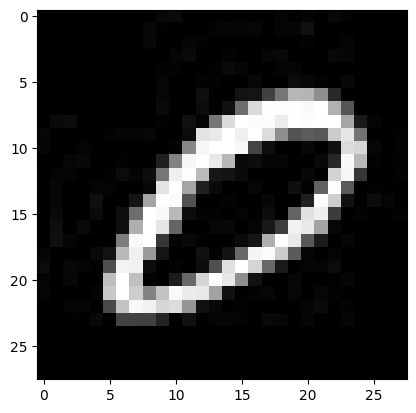

In [40]:
import matplotlib.pyplot as plt
model = DigitClassifier()
model.load_state_dict(torch.load('mnist_digit_classifier.pth'))
model.eval()

image_path = "/content/drive/MyDrive/testSet/img_10001.jpg"
predicted_digit = predict_image(image_path, model)

plt.imshow(Image.open(image_path).convert("L"), cmap='gray')
print(f"The model predicts the digit is: {predicted_digit}")

Saving testimage.jpg to testimage.jpg


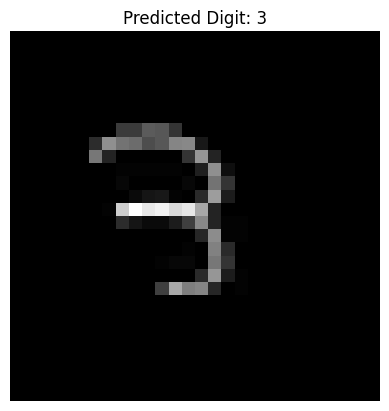

In [ ]:
from google.colab import files
from PIL import Image, ImageOps
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
from PIL.Image import Resampling

# ⏳ Upload image
uploaded = files.upload()

# 🔧 Preprocessing function to match MNIST style
def preprocess_to_mnist_style(image_path):
    image = Image.open(image_path).convert("L")  # Grayscale

    # Invert if necessary (MNIST = white digit on black background)
    image = ImageOps.invert(image)

    # Resize while keeping aspect ratio
    image.thumbnail((20, 20), Resampling.LANCZOS)

    # Create new 28x28 black canvas
    new_image = Image.new("L", (28, 28), 0)
    upper_left_x = (28 - image.width) // 2
    upper_left_y = (28 - image.height) // 2
    new_image.paste(image, (upper_left_x, upper_left_y))

    # Transform to tensor
    transform_pipeline = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    return transform_pipeline(new_image).unsqueeze(0), new_image

# load model
model = DigitClassifier()
model.load_state_dict(torch.load("mnist_digit_classifier.pth"))
model.eval()


for file_name in uploaded.keys():
    image_tensor, processed_image = preprocess_to_mnist_style(file_name)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    #Display result
    plt.imshow(processed_image, cmap='gray')
    plt.title(f"Predicted Digit: {predicted.item()}")
    plt.axis('off')
    plt.show()